In [1]:
### Function to compute point clustering along chord
def computeClustering(nBladePoints,bladeLength,clusteringChordExponent,r_,c_,tol=1.0E-6,printConvergence=False):
    
    xBladePointsClustered = np.zeros((nBladePoints,))

    ds = bladeLength/nBladePoints*np.ones((nBladePoints,))
    for i in range(nBladePoints):
        if (i == 0):
            xBladePointsClustered[i] = 0.5*ds[i]
        else:
            xBladePointsClustered[i] = xBladePointsClustered[i-1] + ds[i]
    
    c = np.interp(xBladePointsClustered,r_,c_)
    eMag = 1.0E6
    n = 1
    if (printConvergence):
        print('iter #','residual')
        
    while (eMag > tol):
        alpha = bladeLength/np.sum(np.power(c,clusteringChordExponent))
        dsClustered = alpha*np.power(c,clusteringChordExponent)
        x_ = np.copy(xBladePointsClustered)
        for i in range(nBladePoints):
            if (i == 0):
                xBladePointsClustered[i] = 0.5*dsClustered[i]
            else:
                xBladePointsClustered[i] = xBladePointsClustered[i-1] + 0.5*dsClustered[i-1] + 0.5*dsClustered[i]
            
        c = np.interp(xBladePointsClustered,r_,c_)
    
        e = x_ - xBladePointsClustered
        eMag = np.sum(np.square(e))
    
        if (printConvergence):
            print(n,eMag)
            
        n = n+1
        
    return xBladePointsClustered,dsClustered,alpha,n,e
        
        

In [2]:
### Load necessary modules.

import numpy as np
import matplotlib.pyplot as plt




In [3]:
### User input.

epsilon = 0.25
bladeLength = 86.4
nBladePointsType = 'auto'
nBladePoints = 10
smoothnessRatio = 0.85
clusteringChordExponent = 1.0


nPlotPoints = 1000
yOffset = [0.0,0.25,0.5,0.75,1.0]
computeBodyForceBeyondTip = 0.01

forcePerUnitLength = 1.0

bladeGeometryFile = '/scratch/mchurchf/equinor.FY22/DTU_10MW/DTU_10MW/BLADEGEO-DTU.dat'




Text(0, 0.5, 'chord (m)')

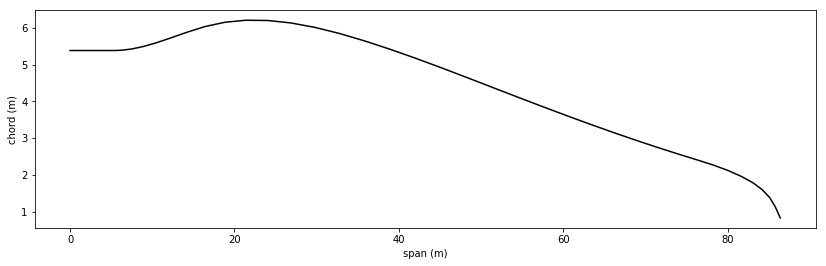

In [4]:
### Read the necessary blade geometry data.

data = np.loadtxt(bladeGeometryFile,skiprows=6)
r_ = data[:,0]
c_ = data[:,5]

plt.figure(figsize=(14.0,4.0))
plt.plot(r_,c_,'k-')
plt.xlabel('span (m)')
plt.ylabel('chord (m)')




2 1000


Text(0, 0.5, 'chord (m)')

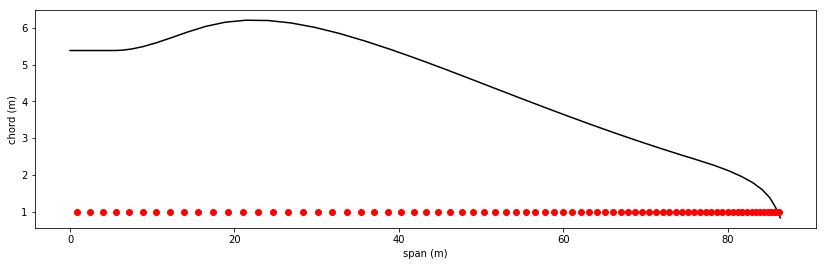

In [5]:
### Compute clustered blade point distribution.

xBladePointsClustered,dsClustered,alpha,n,e = computeClustering(nBladePoints,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)

if (nBladePointsType == 'auto'):
    nL = 2
    nH = 1000
    print(nL,nH)
    while (nH-nL > 1):
        xL,dsL,alphaL,n,e = computeClustering(nL,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)
        xH,dsH,alphaH,n,e = computeClustering(nH,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)
    
        pL = np.max(epsilon*np.interp(xL,r_,c_)/dsL)
        pH = np.max(epsilon*np.interp(xH,r_,c_)/dsH)
    
        errL = np.abs(pL - smoothnessRatio)
        errH = np.abs(pH - smoothnessRatio)
    
        if (errL < errH):
            nH = int(np.round(0.5*(nL + nH)))
        else:
            nL = int(np.round(0.5*(nL + nH)))
        
        
    if (errL <= errH):
        nBladePoints = nL
    else:
        nBladePoints = nH
        
    xBladePointsClustered,dsClustered,alpha,n,e = computeClustering(nBladePoints,bladeLength,clusteringChordExponent,r_,c_,1.0E-6,False)

    



chordClustered = np.interp(xBladePointsClustered,r_,c_)
epsilonClustered = epsilon*chordClustered


plt.figure(figsize=(14.0,4.0))
plt.plot(r_,c_,'k-')
plt.plot(xBladePointsClustered,np.ones((nBladePoints,)),'ro')
plt.xlabel('span (m)')
plt.ylabel('chord (m)')




In [6]:
### Compute uniform blade point distribution.

xBladePointsUniform = np.zeros((nBladePoints,))
dsUniform = bladeLength/nBladePoints*np.ones((nBladePoints,))
for i in range(nBladePoints):
    if (i == 0):
        xBladePointsUniform[i] = 0.5*dsUniform[i]
    else:
        xBladePointsUniform[i] = xBladePointsUniform[i-1] + dsUniform[i]

chordUniform = np.interp(xBladePointsUniform,r_,c_)
epsilonUniform = epsilon*chordUniform




In [7]:
xPlotPoints = np.linspace(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength,nPlotPoints)

gUniform = np.zeros((nPlotPoints,))
gClustered = np.zeros((nPlotPoints,))

fUniform = []
fClustered = []

for m in range(len(yOffset)):   
    fUniform_ = np.zeros((nPlotPoints,))
    fClustered_ = np.zeros((nPlotPoints,))
    
    for i in range(nBladePoints):
        dSqrUniform = np.square(xPlotPoints - xBladePointsUniform[i]) + np.square(yOffset[m])
        dSqrClustered = np.square(xPlotPoints - xBladePointsClustered[i]) + np.square(yOffset[m])
    
        coeffUniform = (1.0/((epsilonUniform[i]**3) * (np.pi**1.5)))
        coeffClustered = (1.0/((epsilonClustered[i]**3) * (np.pi**1.5)))
    
        gUniform = coeffUniform * np.exp(-(dSqrUniform/np.square(epsilonUniform[i])))
        gClustered = coeffClustered * np.exp(-(dSqrClustered/np.square(epsilonClustered[i])))
    
        fUniform_ = fUniform_ + forcePerUnitLength*dsUniform[i]*gUniform
        fClustered_ = fClustered_ + forcePerUnitLength*dsClustered[i]*gClustered
        
    fUniform.append(fUniform_)
    fClustered.append(fClustered_)
    

Text(0, 0.5, 'body force')

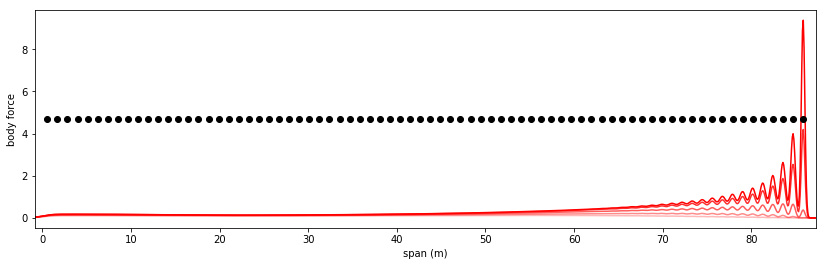

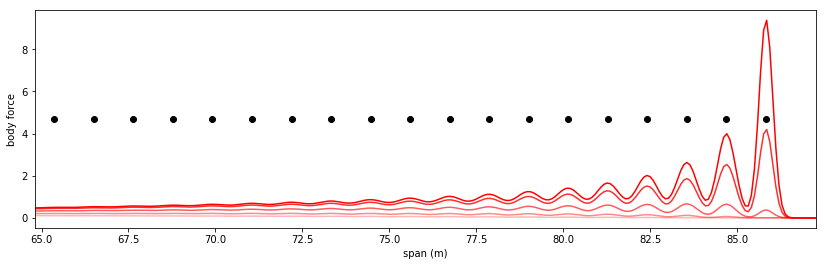

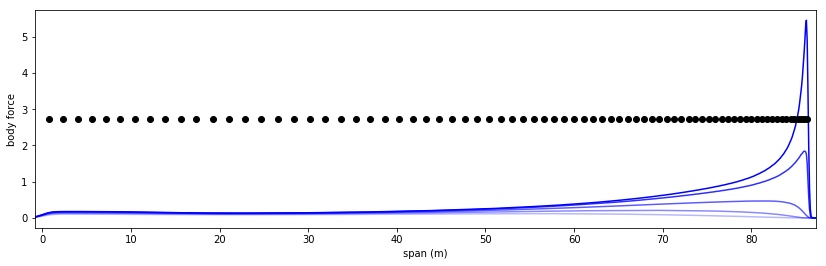

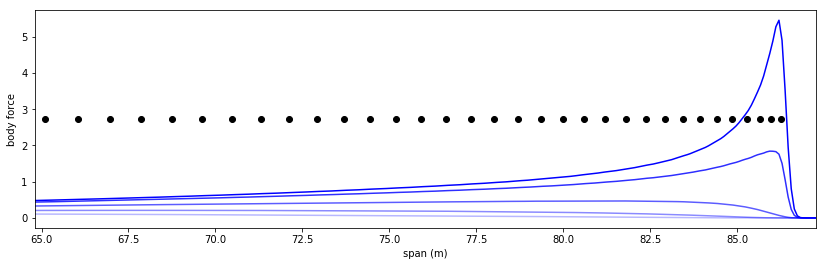

In [8]:
p = 0.5*(np.min(fUniform[0])+np.max(fUniform[0]))

plt.figure(0,figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fUniform[m],'r-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsUniform,p*np.ones(nBladePoints,),'ko')
plt.xlim(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')

plt.figure(1,figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fUniform[m],'r-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsUniform,p*np.ones(nBladePoints,),'ko')
plt.xlim(0.75*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')





p = 0.5*(np.min(fClustered[0])+np.max(fClustered[0]))

plt.figure(figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fClustered[m],'b-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsClustered,p*np.ones(nBladePoints,),'ko')
plt.xlim(-computeBodyForceBeyondTip*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')

plt.figure(figsize=(14.0,4.0))
for m in range(len(yOffset)):
    plt.plot(xPlotPoints,fClustered[m],'b-',alpha=1-(m/len(yOffset))*0.9)
    
plt.plot(xBladePointsClustered,p*np.ones(nBladePoints,),'ko')
plt.xlim(0.75*bladeLength,(1.0+computeBodyForceBeyondTip)*bladeLength)
plt.xlabel('span (m)')
plt.ylabel('body force')




In [ ]:
print(xBladePointsUniform.shape)
print(epsilonUniform.shape)
print(dsUniform.shape)
plt.figure(figsize=(14.0,4.0))
plt.plot(xBladePointsUniform,np.divide(epsilonUniform,dsUniform),'r-')
plt.plot(xBladePointsClustered,np.divide(epsilonClustered,dsClustered),'b-')
plt.xlabel('span (m)')
plt.ylabel('epsilon/ds')
plt.legend(['uniform','clustered'])




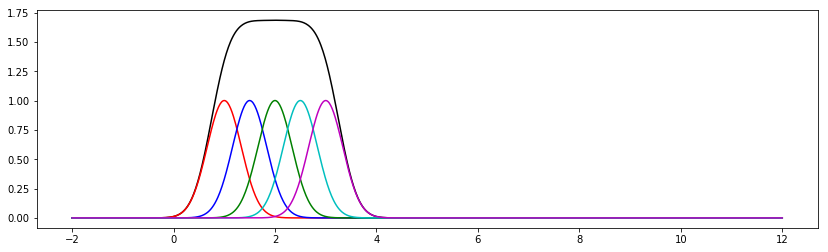

In [10]:
x = np.linspace(-2.0,12.0,1000)
x1 = 1.0
x2 = 1.5
x3 = 2.0
x4 = 2.5
x5 = 3.0
eps = 0.475
f1 = np.exp(-np.square((x-x1)/eps))
f2 = np.exp(-np.square((x-x2)/eps))
f3 = np.exp(-np.square((x-x3)/eps))
f4 = np.exp(-np.square((x-x4)/eps))
f5 = np.exp(-np.square((x-x5)/eps))
f = f1 + f2 + f3 + f4 + f5
plt.figure(figsize=(14,4))
plt.plot(x,f,'k-')
plt.plot(x,f1,'r-')
plt.plot(x,f2,'b-')
plt.plot(x,f3,'g-')
plt.plot(x,f4,'c-')
plt.plot(x,f5,'m-')
#plt.ylim((1.5,1.65))


